Here's some guide for this assessment:

1. Obtain the dataset file from the assessment instruction.
2. The dataset file is split into image and label folder. You need to find a way to read all the images and labels as numpy array.
3. The most straight forward way to read an image is to use OpenCV (cv2.imread())
4. Resize your image and label into width and height of (128,128)
5. For the label, it is in the form of binary mask image (black and white image), you need to find a way to read the mask image, then process the value of the pixels so that they become class label ([0,255] --> [0,1])
6. You can perform train test split on the numpy arrays for the images and labels using scikit learn.
7. You can convert the numpy array into tensorflow tensors using this method: tf.data.Dataset.from_tensor_slices()
8. You can combine the images and labels together to form a single dataset using this method: tf.data.Dataset.zip(), do this for both train and test data.
9. Perform the same dataset preparation step as the demo.
10. Construct a UNet, then train this model so that it reaches at least 80% accuracy for both train and test.
11. Deploy the model and make prediction

(Hint: You can refer to the image segmentation tutorial from tensorflow)

In [1]:
#1. Import packages
import tensorflow as tf
import keras
import tensorboard
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob, os

filepath = "dataset"
images = []
masks = []

In [2]:
#Use os.listdir() method to list down all the image file, then use a for loop to read the images.
"""
for ____ in os.listdir(____):
    function you will use here:
    os.path.join()
    cv2.imread()
    cv2.cvtColor()
    cv2.resize()

Use this for loop, do the same thing for the label. But I suggest you read the label as a grayscale image.
"""

#2. Load images for train
image_path = os.path.join(filepath,'train','inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    train_img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    train_img_np = cv2.cvtColor(train_img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    train_img_np = cv2.resize(train_img_np,(128,128))
    #Place the image into the empty list
    images.append(train_img_np)

# load images for test
image_path = os.path.join(filepath,'test','inputs')
for img in os.listdir(image_path):
    #Get the full path of the image file
    full_path = os.path.join(image_path,img)
    #Read the image file based on the full path
    test_img_np = cv2.imread(full_path)
    #Convert the image from bgr to rgb
    test_img_np = cv2.cvtColor(test_img_np,cv2.COLOR_BGR2RGB)
    #Resize the image into 128x128
    test_img_np = cv2.resize(test_img_np,(128,128))
    #Place the image into the empty list
    images.append(test_img_np)

#3. Load masks for train
mask_path = os.path.join(filepath,'train','masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    train_mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    train_mask_np = cv2.resize(train_mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(train_mask_np)
    
# Load masks for test
mask_path = os.path.join(filepath,'test','masks')
for mask in os.listdir(mask_path):
    #Get the full path of the mask file
    full_path = os.path.join(mask_path,mask)
    #Read the mask file as a grayscale image
    test_mask_np = cv2.imread(full_path,cv2.IMREAD_GRAYSCALE)
    #Resize the image into 128x128
    test_mask_np = cv2.resize(test_mask_np,(128,128))
    #Place the mask into the empty list
    masks.append(test_mask_np)

In [3]:
#4. Convert the list of np array into a full np array
images_np = np.array(images)
masks_np = np.array(masks)

In [4]:
#5. Data preprocessing
#5.1. Expand the mask dimension to include the channel axis
masks_np_exp = np.expand_dims(masks_np,axis=-1)
#5.2. Convert the mask value into just 0 and 1
converted_masks_np = np.round(masks_np_exp/255)
#5.3. Normalize the images pixel value
normalized_images_np = images_np/255.0

In [5]:
#6. Perform train test split
from sklearn.model_selection import train_test_split
SEED = 12345
X_train,X_test,y_train,y_test = train_test_split(normalized_images_np,converted_masks_np,shuffle=True,random_state=SEED)

In [6]:
#7. Convert the numpy array into tensorflow tensors
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [7]:
#8. Combine features and labels together to form a zip dataset
train = tf.data.Dataset.zip((X_train_tensor,y_train_tensor))
test = tf.data.Dataset.zip((X_test_tensor,y_test_tensor))

In [8]:
"""
Continue the rest of your assessment here.
"""
#Convert the zip dataset into prefetch dataset

'\nContinue the rest of your assessment here.\n'

In [9]:
TRAIN_LENGTH = 502
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
# create an augmentation
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [11]:
train_batches = (
    train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

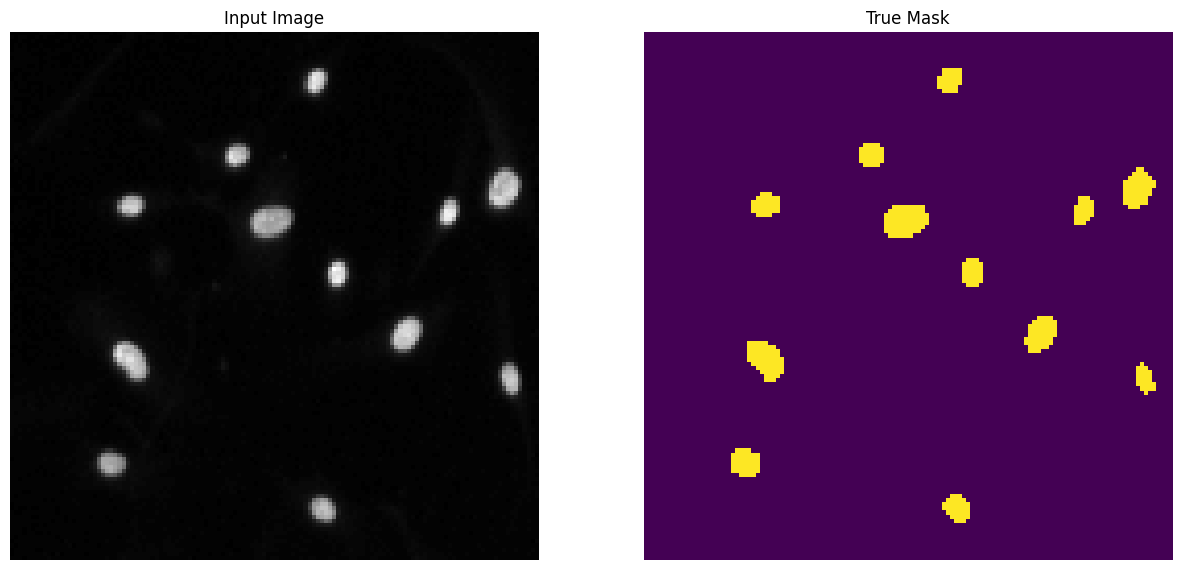

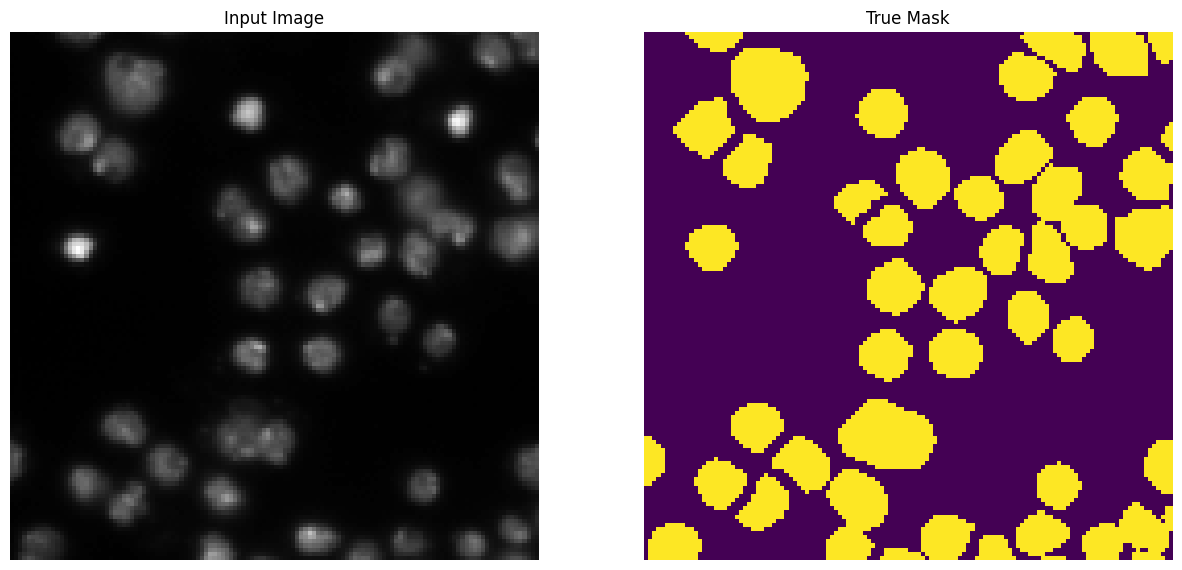

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

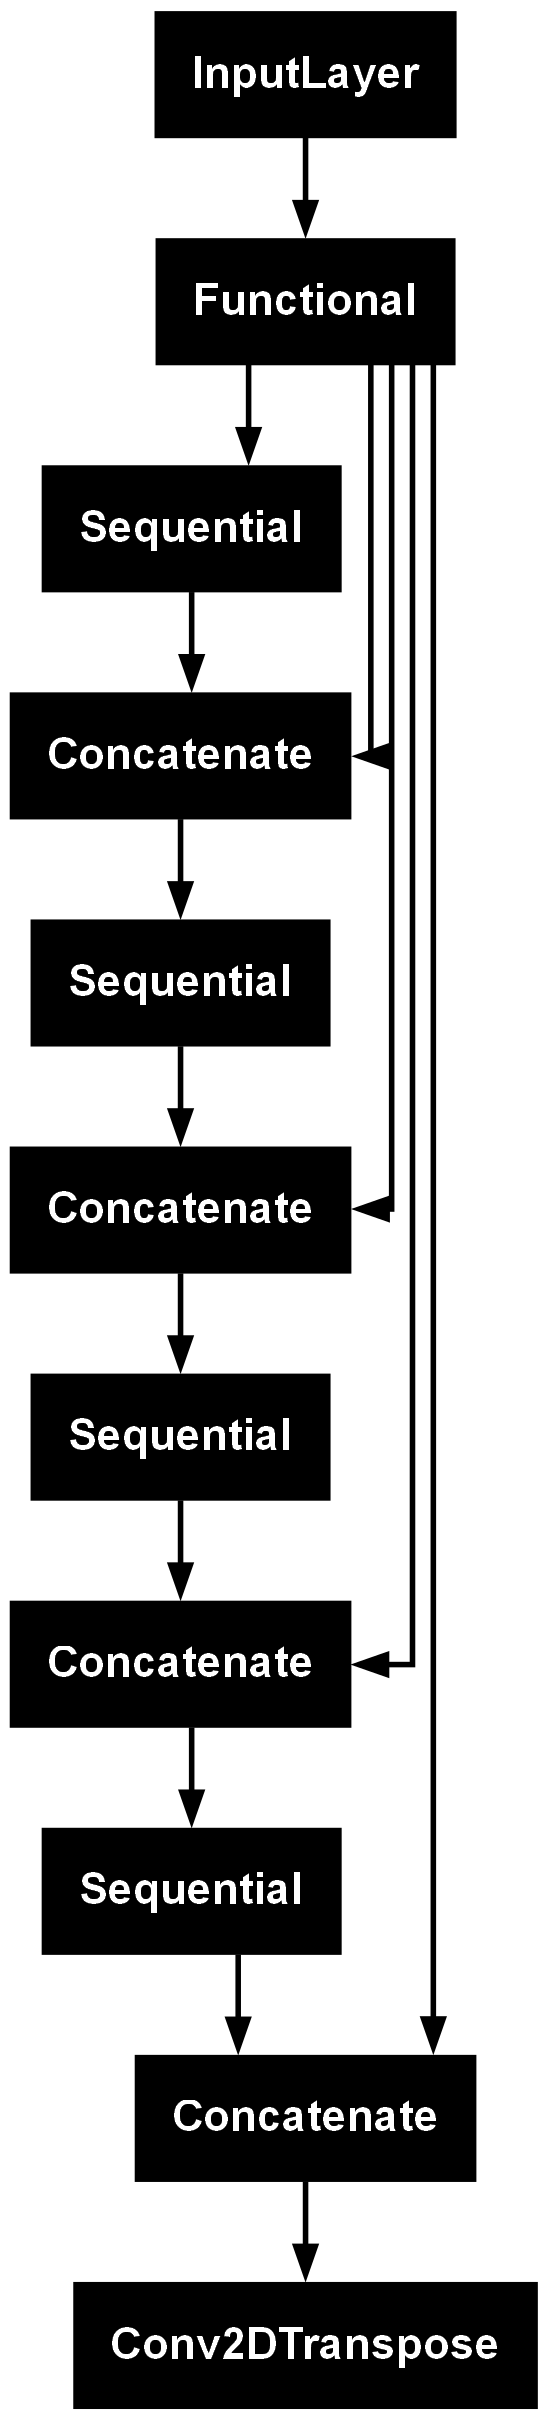

In [18]:
tf.keras.utils.plot_model(model)

In [19]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 64, 64,   │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8, 8, 512) │  1,476,608 │ functional[0][4]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 16, 16,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │      2,882 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 2)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,502,786 (24.81 MB)

 Trainable params: 4,658,882 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


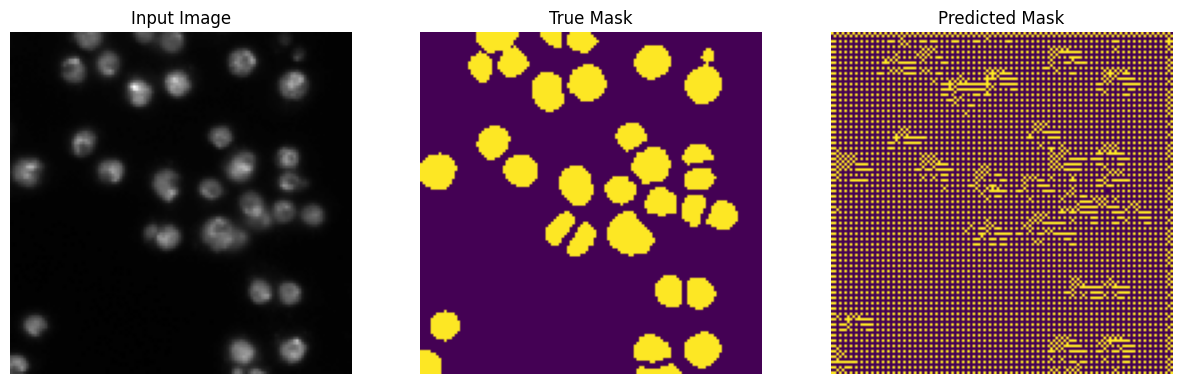

In [22]:
show_predictions()

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [24]:
# to help log tensorboard
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


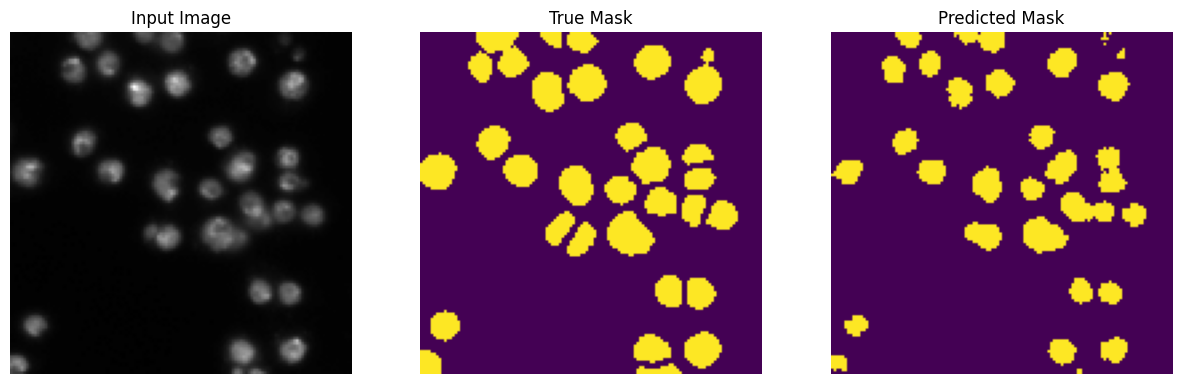


Sample Prediction after epoch 25

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 943ms/step - accuracy: 0.9604 - loss: 0.0959 - val_accuracy: 0.9459 - val_loss: 0.1206
Epoch 25: early stopping


In [25]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 502//BATCH_SIZE//VAL_SUBSPLITS
log_path = f'logs/{timestamp}/'
ts = keras.callbacks.TensorBoard(log_dir=log_path)  
es = keras.callbacks.EarlyStopping(patience=5, verbose=1)
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),ts,es])

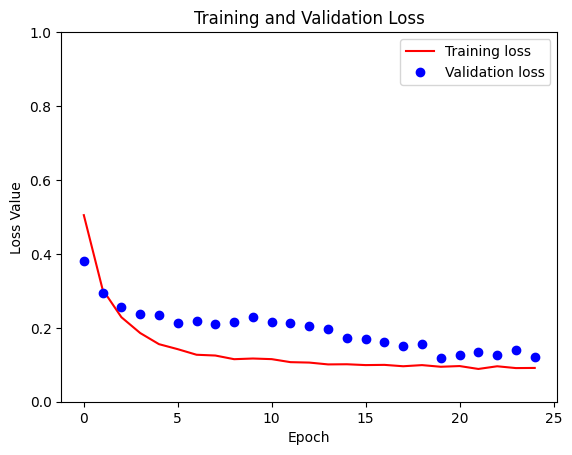

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


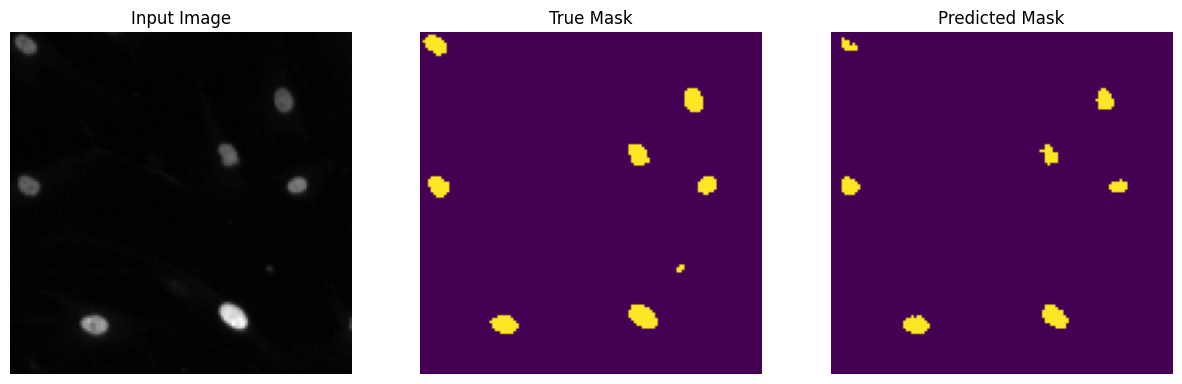

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


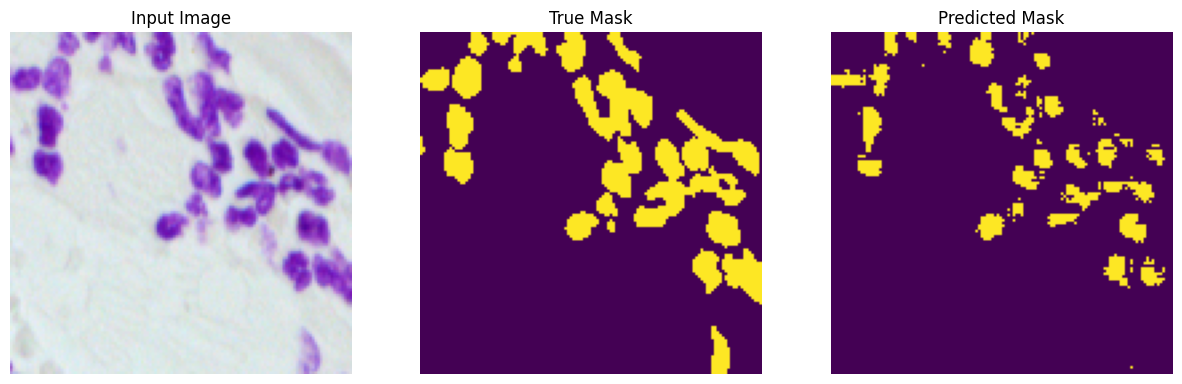

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


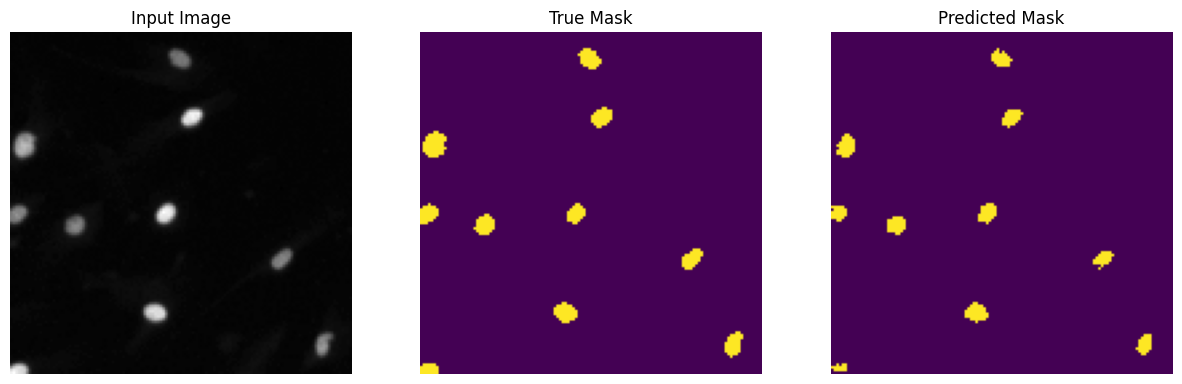

In [27]:
show_predictions(test_batches, 3)